
## Unsupervised Exploration of Iris Dataset
In this notebook, we explore and analyze the Iris dataset. The Iris dataset contains measurements of 3 different species of Iris flowers, for each flower, there are 4 measurements. We wrote two models to fit the data distribution, the second model is an expansion of the first. We preformed model checking and examine the ability of the models to distinguish between the different species of Iris flowers in the dataset.  

![alt text](https://4.bp.blogspot.com/-hr_5CEbsCI8/T3Lh7a7E3yI/AAAAAAAAEAQ/0DO1DtMW53c/s1600/IMG_2748web.jpg)

In [ ]:
import pystan
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
! pip install arviz
import arviz as az
import csv
import scipy
import matplotlib.colors as colors
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from scipy.stats import randint
import pandas as pd

     |████████████████████████████████| 1.5MB 3.3MB/s 
     |████████████████████████████████| 4.1MB 26.5MB/s 
     |████████████████████████████████| 286kB 45.3MB/s 


In [ ]:
iris = load_iris()
iris_data = np.array(iris['data']);
y = StandardScaler(with_std=False).fit_transform(iris_data)
iris_labels = np.array(iris['target']);


# Data Exploration :
From the visualization of the data below, We cannot definitively determine that the data was generated from measurements of three separate groups. The only attribute alluding that there are three groups is the sepal length, from the spread of the septal width we might think there is only one group. From the two measurements of the petals, it seems like there are two separate groups. Even if we did not know the data came from the measurement of three species of Iris, the spread of the septal length will lead us to look for a model with three groups, maybe even four. (the data is centered to have zero mean on each feature)


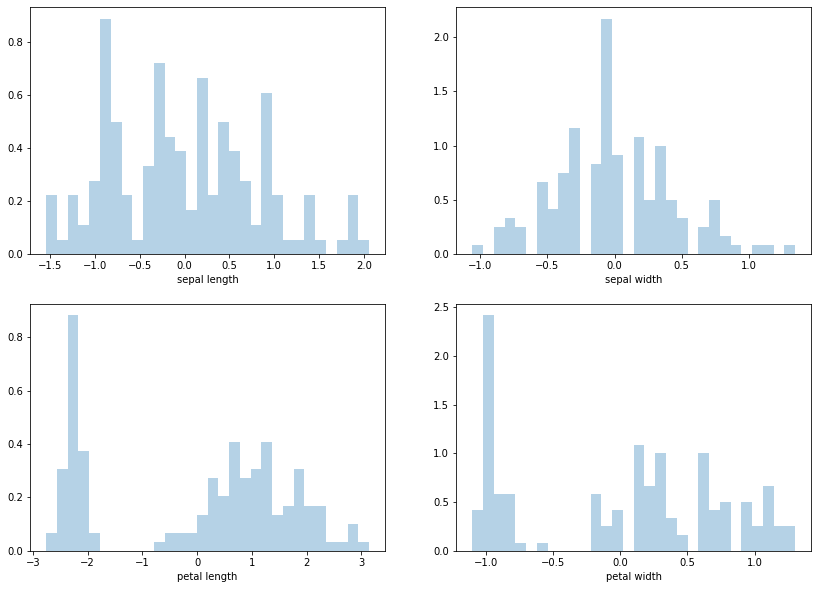

In [ ]:
fig, axes = plt.subplots(2, 2,figsize=(14,10))
axes[0,0].set_xlabel("sepal length");
axes[0,1].set_xlabel("sepal width");
axes[1,0].set_xlabel("petal length");
axes[1,1].set_xlabel("petal width");
n_bins = 30;
axes[0,0].hist(y[:,0], bins=n_bins, density=True,alpha =0.33);
axes[0,1].hist(y[:,1], bins=n_bins, density=True,alpha =0.33);
axes[1,0].hist(y[:,2], bins=n_bins, density=True,alpha =0.33);
axes[1,1].hist(y[:,3], bins=n_bins, density=True,alpha =0.33);


We don't want to create a complicated multivariant mixture model, but a one-dimensional one. For that, we will project the data on some axis. A first estimation of the best projection direction is the axis with the highest variance, achieved by PCA. Let us check how the data distributed in this direction. (remember the data was centered)  

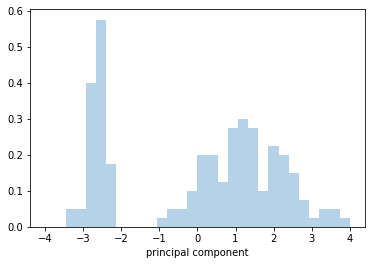

In [ ]:
pca = PCA(n_components=4)
principal_components  = pca.fit_transform(y)
beta_pca = np.array(pca.components_[0, :])
data = principal_components[:,0]
fig, axes = plt.subplots(1, 1);
axes.hist(data,bins=n_bins, density=True, range = (-4,4),alpha =0.33);
axes.set_xlabel("principal component");

#Initial Model Specification:
The model we propose defines a linear combination of each data point to achieve a one-dimensional representation of each data point. The model uses the principal direction from PCA as a point estimation of the combination coefficients. The one-dimensional data will be modeled as a GMM of three ,with shared variance. The data was created from an equal number of Iris flowers from each species, therefore the proportion between the components is chosen as constant and uniform.  


In [ ]:
  model_data = {'K': 3,
                'N': 150,
                'D': 4,
                'beta': beta_pca,
                'y': y
                }

In [ ]:
 model = """
    data {
     int<lower=1> K;          // number of mixture components
     int<lower=1> N;          // number of data points
     int<lower=1> D;          // observations dimention - number of features
     vector[D] beta;          // projection direcrtion 
     matrix[N,D] y;           // observations
    }

    parameters {
      ordered[K] mu;             // locations of mixture components
      real<lower=0> sigma;  // scales of mixture components
    }
    
    model {
      vector[N] reg = y*beta; 
      vector[K] theta = [ 1.0/3.0, 1.0/3.0, 1.0/3.0]';
      vector[K] log_theta = log(theta);  // cache log calculation
      sigma ~ lognormal(0, 2);
      mu ~ normal(0, 10);
      for (n in 1:N) {
        vector[K] lps = log_theta;
        for (k in 1:K)
          lps[k] += normal_lpdf(reg[n] | mu[k], sigma);
        target += log_sum_exp(lps);
      }
    }

    """

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76d38d12ef05e3b50ce148e2b04b730d NOW.


Inference for Stan model: anon_model_76d38d12ef05e3b50ce148e2b04b730d.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]  -2.63 10.0e-4   0.08  -2.79  -2.68  -2.63  -2.57  -2.47   6721    1.0
mu[2]   0.62  1.1e-3    0.1   0.41   0.55   0.62   0.68   0.81   8426    1.0
mu[3]   2.17  1.2e-3   0.12   1.95   2.09   2.17   2.25   2.41  10128    1.0
sigma   0.56  4.9e-4   0.04   0.49   0.53   0.56   0.59   0.65   7265    1.0
lp__  -264.5    0.02   1.47 -268.2 -265.2 -264.2 -263.4 -262.6   4410    1.0

Samples were drawn using NUTS at Mon Jul 13 19:47:03 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


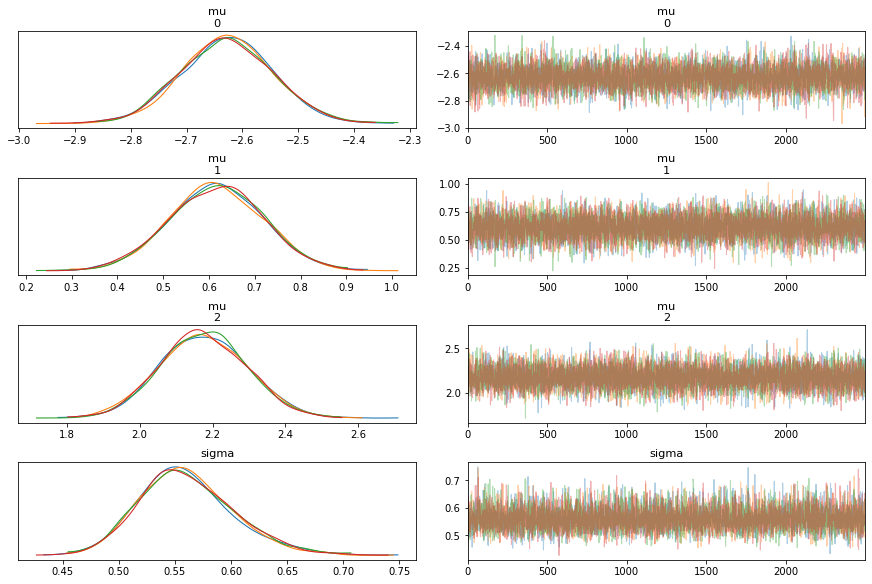

In [ ]:
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=model_data, iter=5000, chains=4,n_jobs=4)
print(fit)
_ = az.plot_trace(fit)

# Posterior Inferance

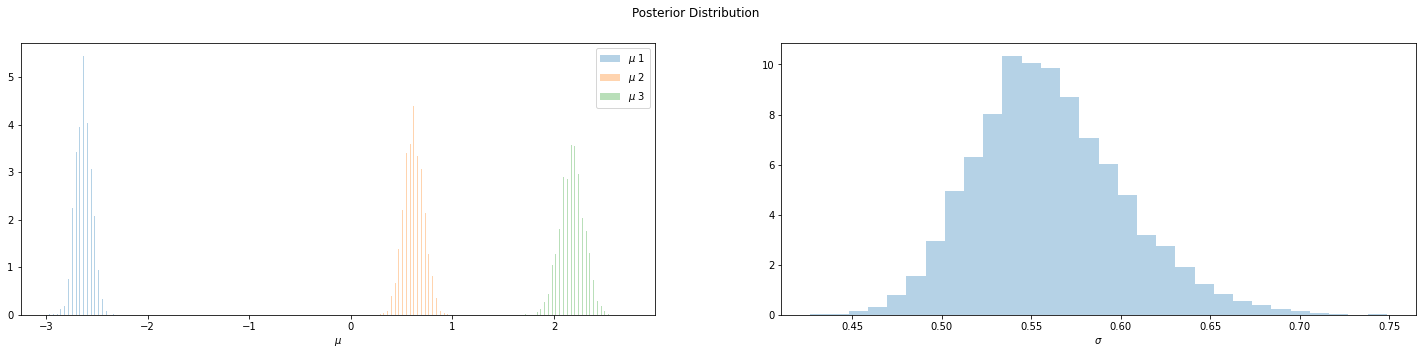

In [ ]:
mu_m1 = fit.extract()['mu']
sigma_m1 = fit.extract()['sigma']
mu = mu_m1
sigma = sigma_m1
fig, axes = plt.subplots(1, 2 , figsize = (25,5))
axes[0].set_xlabel(r'$\mu$')
axes[1].set_xlabel(r'$\sigma$')

n_bins = 30;
axes[0].hist(mu, bins=1000, density=True,alpha =0.33,label=["$\mu$ 1","$\mu$ 2","$\mu$ 3"]);
axes[0].legend()
axes[1].hist(sigma, bins=n_bins, density=True,alpha =0.33);
fig.suptitle("Posterior Distribution");

The graph above show the posterior distribution of  $\sigma$ and $\mu$ for each componant of the mixture. If we compare this results to the distribition of the data principal component, all values of $\mu$ are plausible.  



# Predictive Posterior Checks
Because the data we can generate is the projection on the main axis of the data, it is hard to compare the results of the sampling to our general knowledge of the world and specifically the knowledge about Iris flower features. We can compare the predicted samples to the projection of the original data on the same main axis. 

In [ ]:
#generate draws from predictiv distrobution 

N = 150
K = 3
n_sim = len(mu)
y_rep = np.zeros((n_sim,N))
y_rep_c0 = np.zeros((n_sim,50))
y_rep_c1 = np.zeros((n_sim,50))
y_rep_c2 = np.zeros((n_sim,50))
for i in range(0,n_sim):
  rep = np.random.normal(mu[i,],sigma[i],size=(50,K))
  y_rep_c0[i] = rep[:,0]
  y_rep_c1[i] = rep[:,1]
  y_rep_c2[i] = rep[:,2]
  y_rep[i] = rep.reshape(N)

  


We created 10,000 simulations of the original experiment, drawing 150 values, 50 from each component of the mixture. From a quick look at a sample from the predictive distribution it seems as the general structure is similar. The major difference clear to the eye is the sharpness of the peaks in the histogram, so it will be interesting to check this quantity.

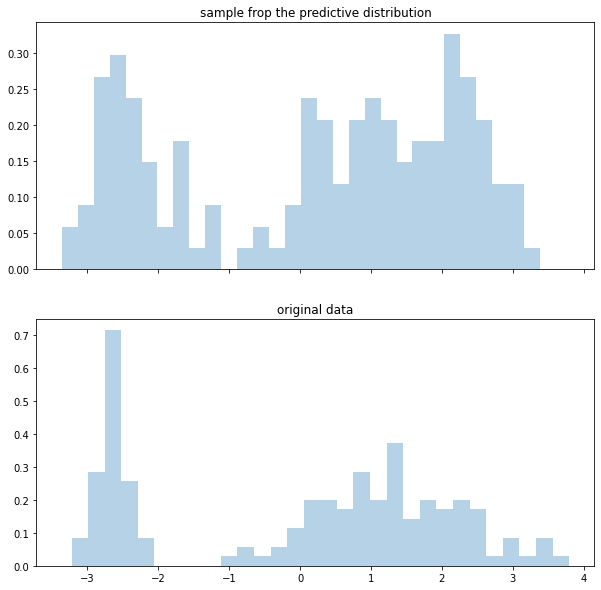

In [ ]:

fig,axes = plt.subplots(2,1,sharex=True,figsize=(10,10));
axes[0].hist(y_rep[0],bins=n_bins,density=True,alpha =0.33);
axes[0].set_title("sample frop the predictive distribution");
axes[1].hist(data,bins=n_bins,density=True,alpha =0.33);
axes[1].set_title("original data");


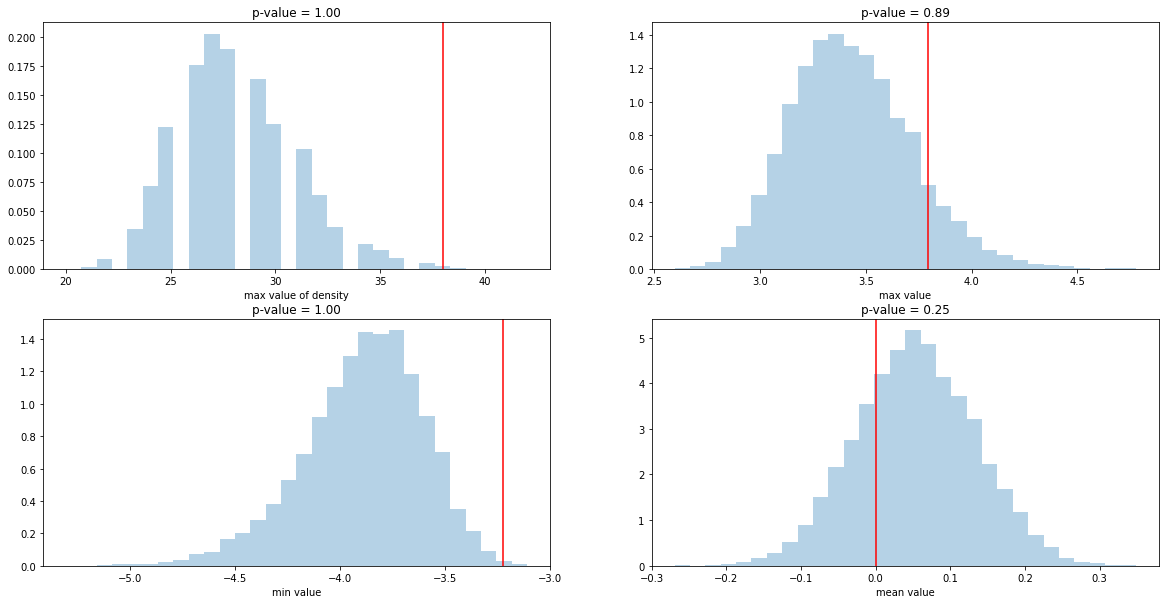

In [ ]:
#test quantities
max = np.max(y_rep,1)
min = np.min(y_rep,1)
mean = np.mean(y_rep,1)
hist_max=np.zeros(n_sim)
data_hist,_ = np.histogram(data)
for i in range(0,n_sim):
  hist,_ = np.histogram(y_rep[i])
  hist_max[i]=np.max(hist)

fig,axes = plt.subplots(2,2,figsize = (20,10))
axes[0,0].hist(hist_max,bins=n_bins,density=True,alpha =0.33);
axes[0,1].hist(max,bins=n_bins,density=True,alpha =0.33);
axes[1,0].hist(min,bins=n_bins,density=True,alpha =0.33);
axes[1,1].hist(mean,bins=n_bins,density=True,alpha =0.33);
axes[0,0].set_xlabel("max value of density");
axes[0,1].set_xlabel("max value");
axes[1,0].set_xlabel("min value");
axes[1,1].set_xlabel("mean value");
axes[0,0].axvline(np.max(data_hist), color="red");
axes[0,1].axvline(np.max(data), color="red");
axes[1,0].axvline(np.min(data), color="red");
axes[1,1].axvline(np.mean(data), color="red");
axes[0,0].set_title("p-value = {:.2f}".format(len(hist_max[hist_max < np.max(data_hist)])/n_sim));
axes[0,1].set_title("p-value = {:.2f}".format(len(max[max < np.max(data)])/n_sim));
axes[1,0].set_title("p-value = {:.2f}".format(len(min[min < np.min(data)])/n_sim));
axes[1,1].set_title("p-value = {:.2f}".format(len(min[mean < np.mean(data)])/n_sim));

The test quantities we choose demonstrate that the model does not represent the data well, although the main structure is similar. It seems that the modeled distribution is biased to the left as the minimum values and the maximum values are smaller in general from the minimum or maximum in the data. Another difference is the concentration of the distribution, in time that the data is very constrained around the centers with high pike, the modeled distribution is spread wider and lower. We will check also the test quantinty for each componant of the mixture seperatly. 

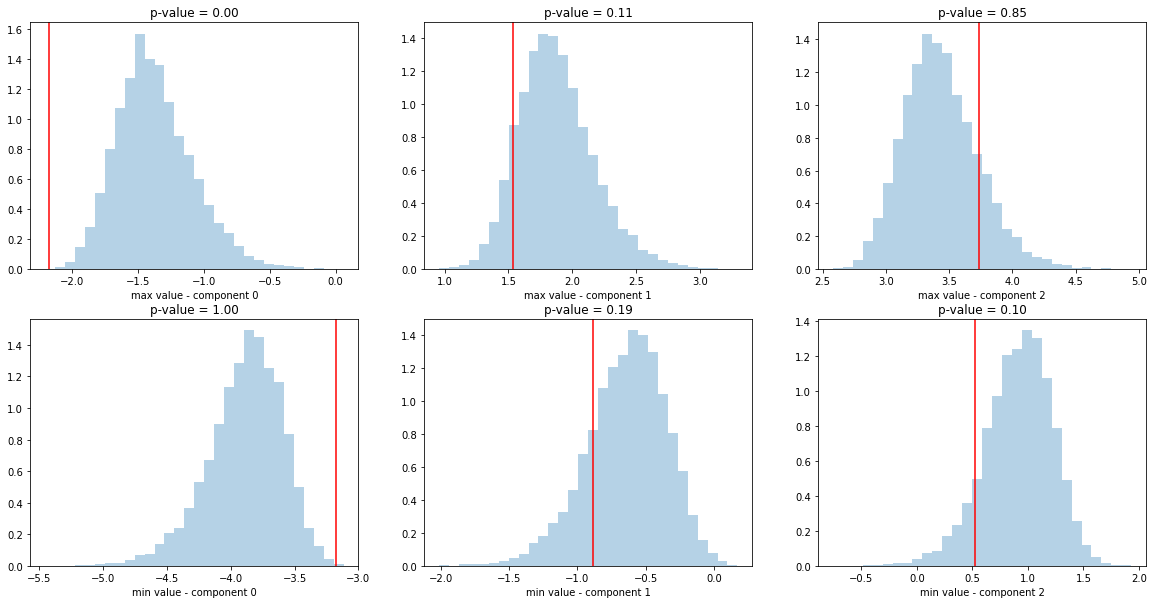

In [ ]:
max = [np.max(y_rep_c0,1),np.max(y_rep_c1,1),np.max(y_rep_c2,1)]
min = [np.min(y_rep_c0,1),np.min(y_rep_c1,1),np.min(y_rep_c2,1)]
hist_max=np.zeros((3,n_sim))
data_hist,_ = np.histogram(data)

fig,axes = plt.subplots(2,3,figsize = (20,10))
for i in range(K):
  axes[0,i].hist(max[i],bins=n_bins,density=True,alpha =0.33);
  axes[1,i].hist(min[i],bins=n_bins,density=True,alpha =0.33);
  axes[0,i].axvline(np.max(data[iris_labels == i]), color="red");
  axes[1,i].axvline(np.min(data[iris_labels == i]), color="red");
  axes[0,i].set_xlabel("max value - component "+str(i));
  axes[1,i].set_xlabel("min value - component "+str(i));
  axes[0,i].set_title("p-value = {:.2f}".format(len(max[i][max[i] < np.max(data[iris_labels==i])])/n_sim));
  axes[1,i].set_title("p-value = {:.2f}".format(len(min[i][min[i] < np.min(data[iris_labels==i])])/n_sim));



still not great represntation of the data even one component at a time.

# sensitivity analysis
How much does $\sigma$ effect the distribution of $\mu$. This is the question we want to answer in this section, in a manner to understand if we want to restrict the prior on $\sigma$ and if yes to which range? 

Text(0, 0.5, '$ std( \\mu | \\sigma)$')

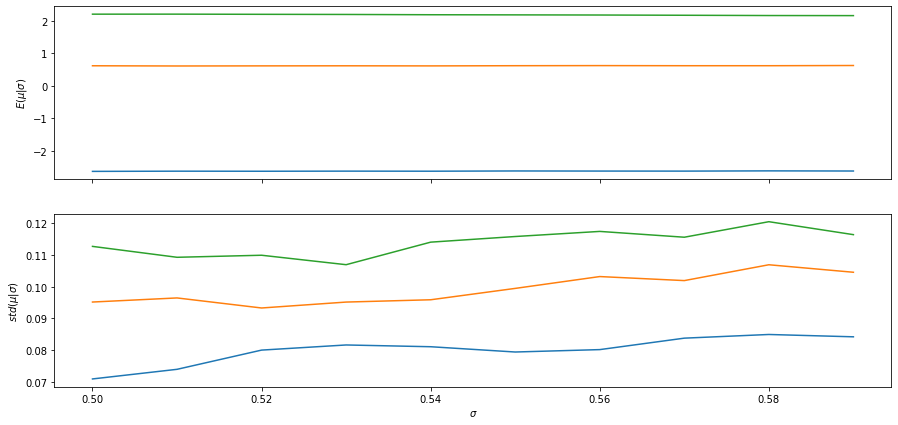

In [ ]:


E_mu_given_sigma = np.zeros((10,3))
std_mu_given_sigma  = np.zeros((10,3))
for i in range(10):
  min_sigma = 0.5+0.01*i
  max_sigma = min_sigma +0.01
  E_mu_given_sigma[i] = np.mean(mu[(sigma>min_sigma) & (sigma<max_sigma),:],0)
  std_mu_given_sigma[i] = np.std(mu[(sigma>min_sigma) & (sigma<max_sigma),:],0)



fig,axes = plt.subplots(2,1,sharex=True,figsize=(15,7))
axes[0].plot(np.arange(0.5,0.6,0.01),E_mu_given_sigma)
axes[1].plot(np.arange(0.5,0.6,0.01),std_mu_given_sigma)
axes[1].set_xlabel("$\sigma$")
axes[0].set_ylabel("$ E(\mu | \sigma)$")
axes[1].set_ylabel("$ std( \mu | \sigma)$")

We see here that the mean of $\mu$ is not semsative to $\sigma$, in contrast the standart deviation of $\mu$ is effected by $\sigma$ and it is lower for lower values of $\sigma$. We may conclude we shuold narrow the prior on $\sigma$ to be around 0.5. 

# Expansion of the Model
In the first model, we used a projection on an axis that was achieved using PCA. This is actually a point estimation of the best direction to project the data on. On this expanded model we will define the projection direction as a parameter of the model instead of using the point estimation. 

In [ ]:
 model_data = {'K': 3,
                'N': 150,
                'D': 4,
                'beta_prior': beta_pca, 
                'y': y
                }

model = """
      data {
      int<lower=1> K;          // number of mixture components
      int<lower=1> N;          // number of data points
      int<lower=1> D;          // observations dimention - number of features
      vector[D] beta_prior;         // projection direcrtion 
      matrix[N,D] y;           // observations
      }

      parameters {
        ordered[K] mu;          // locations of mixture components
        real<lower=0> sigma;    // scales of mixture components
        vector[D] beta;         // projection direcrtion 
      }

      model {
        vector[N] reg = y*beta; 
        vector[K] theta = [ 1.0/3.0, 1.0/3.0, 1.0/3.0]';
        vector[K] log_theta = log(theta);  // cache log calculation
        beta ~ normal(beta_prior,0.01);
        sigma ~ lognormal(0, 2);
        mu ~ normal(0, 10);
        for (n in 1:N) {
          vector[K] lps = log_theta;
          for (k in 1:K)
            lps[k] += normal_lpdf(reg[n] | mu[k], sigma);
          target += log_sum_exp(lps);
        }
      }

      """

In [ ]:
sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=model_data, iter=5000, chains=4,n_jobs=4)
print(fit)
_ = az.plot_trace(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d21cfa63ba1aa0386282198a491b55b NOW.


Inference for Stan model: anon_model_9d21cfa63ba1aa0386282198a491b55b.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]    -2.59  9.6e-4    0.08  -2.76  -2.65  -2.59  -2.53  -2.43   7640    1.0
mu[2]     0.61  9.5e-4     0.1   0.41   0.54   0.61   0.67    0.8  10800    1.0
mu[3]     2.14  1.1e-3    0.12   1.91   2.06   2.14   2.22   2.37  11253    1.0
sigma     0.55  4.0e-4    0.04   0.48   0.52   0.55   0.58   0.64  10310    1.0
beta[1]   0.35  8.8e-5    0.01   0.33   0.35   0.35   0.36   0.37  12966    1.0
beta[2]  -0.09  8.4e-5 10.0e-3  -0.11  -0.09  -0.09  -0.08  -0.07  14266    1.0
beta[3]   0.84 10.0e-5    0.01   0.82   0.84   0.84   0.85   0.86  10226    1.0
beta[4]   0.35  8.7e-5    0.01   0.33   0.35   0.35   0.36   0.37  13326    1.0
lp__    -265.2    0.03    2.08 -270.1 -266.3 -264.8 -263.6 -262.2   4351    1.0

Samples w

We understand there is not much of a difference between the direction in the first model and the one achieved in this expanded model. This happens due to the small variance of the prior on $\beta$. We discovered that for larger variance the model did not converge properly. We will check if this small tuning will make a difference. 

# Posterior Inferance

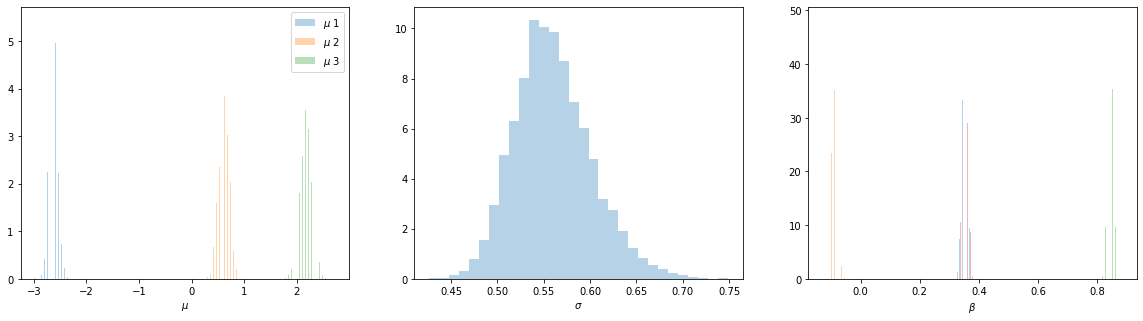

In [ ]:
mu_m2 = fit.extract()['mu']
sigma_m2 = fit.extract()['sigma']
beta_m2 = fit.extract()['beta']
mu = mu_m1
sigma = sigma_m1
beta = beta_m2

fig, axes = plt.subplots(1, 3 , figsize = (20,5))
axes[0].set_xlabel(r'$\mu$')
axes[1].set_xlabel(r'$\sigma$')
axes[2].set_xlabel(r'$\beta$')

n_bins = 30;
axes[0].hist(mu, bins=1000, density=True,alpha =0.33,label=["$\mu$ 1","$\mu$ 2","$\mu$ 3"]);
axes[0].legend()
axes[1].hist(sigma, bins=n_bins, density=True,alpha =0.33);
axes[2].hist(beta, bins=2000, density=True,alpha =0.33);


# Predictive Posterior Checks

In [ ]:
#generate draws from predictiv distrobution 

N = 150
K = 3
n_sim = len(mu)
y_rep = np.zeros((n_sim,N))
y_rep_c0 = np.zeros((n_sim,50))
y_rep_c1 = np.zeros((n_sim,50))
y_rep_c2 = np.zeros((n_sim,50))
for i in range(0,n_sim):
  rep = np.random.normal(mu[i,],sigma[i],size=(50,K))
  y_rep_c0[i] = rep[:,0]
  y_rep_c1[i] = rep[:,1]
  y_rep_c2[i] = rep[:,2]
  y_rep[i] = rep.reshape(N)

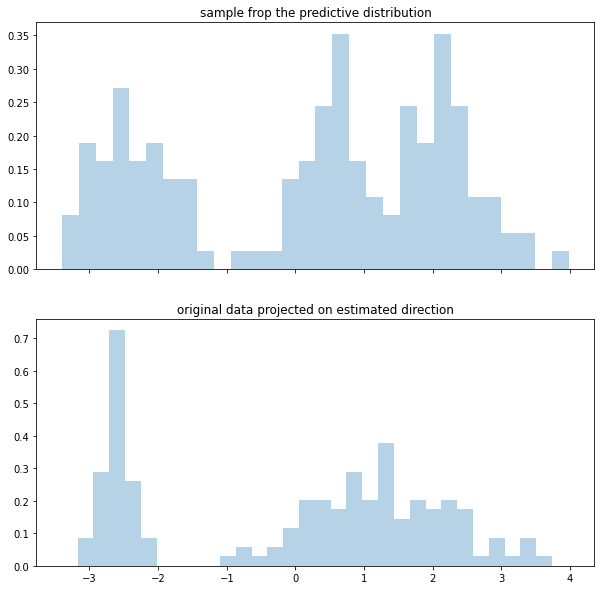

In [ ]:
beta_mean = np.mean(beta,0)
data = np.dot(y,beta_mean)
fig,axes = plt.subplots(2,1,sharex=True,figsize=(10,10));
axes[0].hist(y_rep[0],bins=n_bins,density=True,alpha =0.33);
axes[0].set_title("sample frop the predictive distribution");
axes[1].hist(data,bins=n_bins,density=True,alpha =0.33);
axes[1].set_title("original data projected on estimated direction");


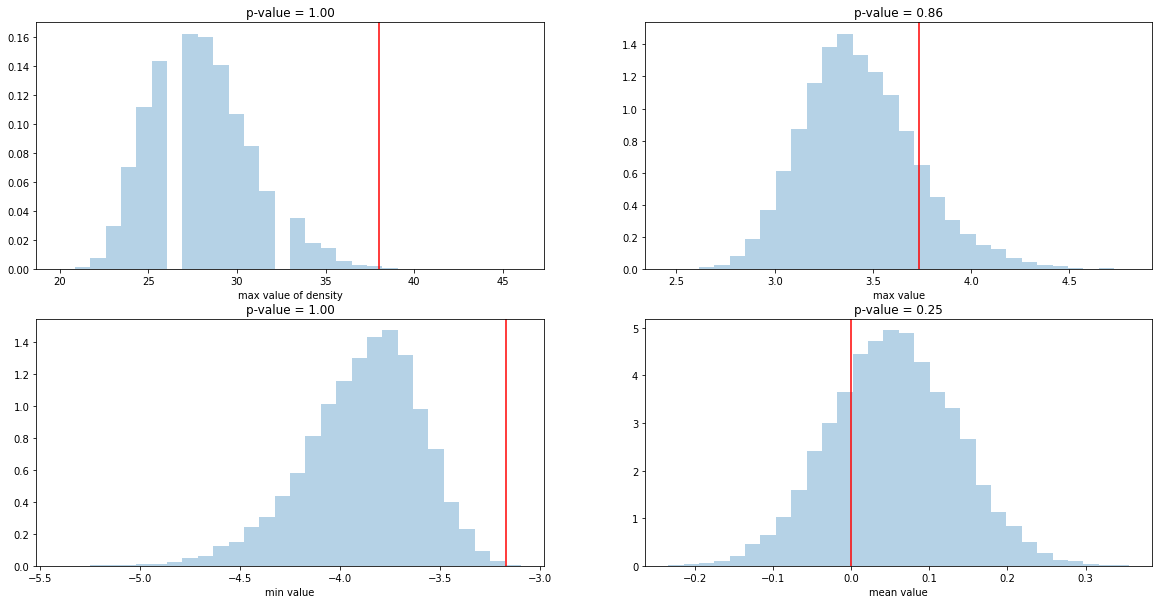

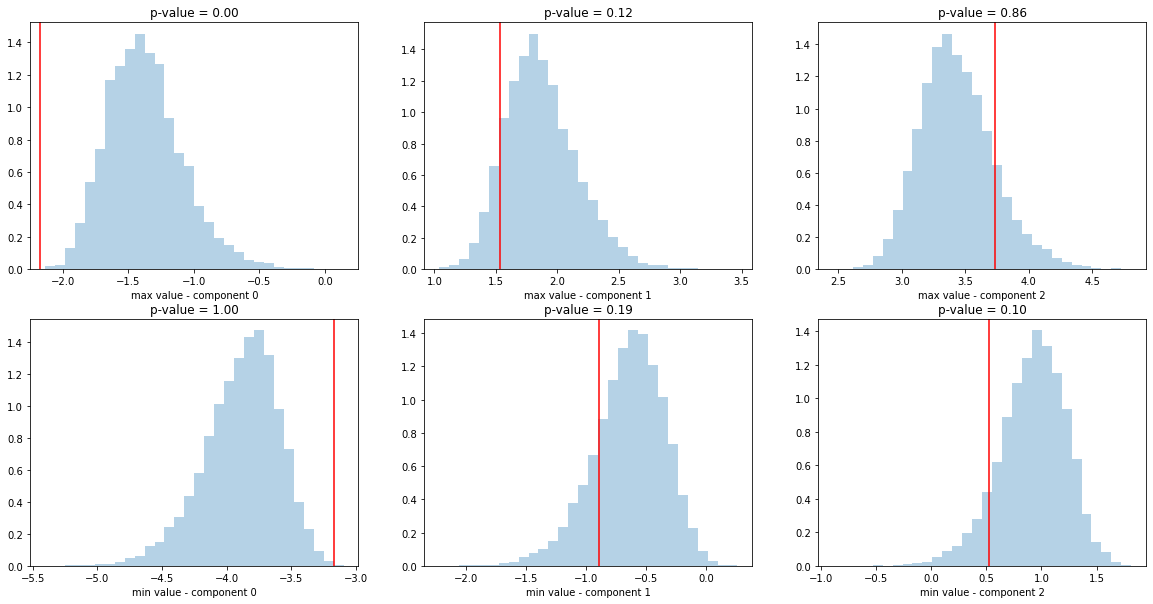

In [ ]:
#test quantities
max = np.max(y_rep,1)
min = np.min(y_rep,1)
mean = np.mean(y_rep,1)
hist_max=np.zeros(n_sim)
data_hist,_ = np.histogram(data)
for i in range(0,n_sim):
  hist,_ = np.histogram(y_rep[i])
  hist_max[i]=np.max(hist)

fig,axes = plt.subplots(2,2,figsize = (20,10));
axes[0,0].hist(hist_max,bins=n_bins,density=True,alpha =0.33);
axes[0,1].hist(max,bins=n_bins,density=True,alpha =0.33);
axes[1,0].hist(min,bins=n_bins,density=True,alpha =0.33);
axes[1,1].hist(mean,bins=n_bins,density=True,alpha =0.33);
axes[0,0].set_xlabel("max value of density");
axes[0,1].set_xlabel("max value");
axes[1,0].set_xlabel("min value");
axes[1,1].set_xlabel("mean value");
axes[0,0].axvline(np.max(data_hist), color="red");
axes[0,1].axvline(np.max(data), color="red");
axes[1,0].axvline(np.min(data), color="red");
axes[1,1].axvline(np.mean(data), color="red");
axes[0,0].set_title("p-value = {:.2f}".format(len(hist_max[hist_max < np.max(data_hist)])/n_sim));
axes[0,1].set_title("p-value = {:.2f}".format(len(max[max < np.max(data)])/n_sim));
axes[1,0].set_title("p-value = {:.2f}".format(len(min[min < np.min(data)])/n_sim));
axes[1,1].set_title("p-value = {:.2f}".format(len(min[mean < np.mean(data)])/n_sim));

max = [np.max(y_rep_c0,1),np.max(y_rep_c1,1),np.max(y_rep_c2,1)]
min = [np.min(y_rep_c0,1),np.min(y_rep_c1,1),np.min(y_rep_c2,1)]

fig,axes = plt.subplots(2,3,figsize = (20,10))
for i in range(K):
  axes[0,i].hist(max[i],bins=n_bins,density=True,alpha =0.33);
  axes[1,i].hist(min[i],bins=n_bins,density=True,alpha =0.33);
  axes[0,i].axvline(np.max(data[iris_labels == i]), color="red");
  axes[1,i].axvline(np.min(data[iris_labels == i]), color="red");
  axes[0,i].set_xlabel("max value - component "+str(i));
  axes[1,i].set_xlabel("min value - component "+str(i));
  axes[0,i].set_title("p-value = {:.2f}".format(len(max[i][max[i] < np.max(data[iris_labels==i])])/n_sim));
  axes[1,i].set_title("p-value = {:.2f}".format(len(min[i][min[i] < np.min(data[iris_labels==i])])/n_sim));

There no difference here from the previous model. The data values were achieved by projecting the data on the mean $\beta$ , this is almost equal to the original direction. 

#sensitivity analysis

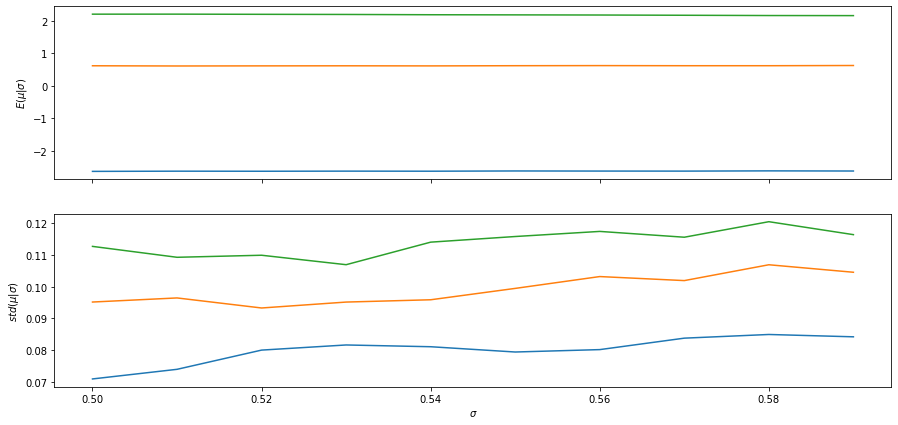

In [ ]:

E_mu_given_sigma = np.zeros((10,3))
std_mu_given_sigma  = np.zeros((10,3))
for i in range(10):
  min_sigma = 0.5+0.01*i
  max_sigma = min_sigma +0.01
  E_mu_given_sigma[i] = np.mean(mu[(sigma>min_sigma) & (sigma<max_sigma),:],0)
  std_mu_given_sigma[i] = np.std(mu[(sigma>min_sigma) & (sigma<max_sigma),:],0)


fig,axes = plt.subplots(2,1,sharex=True,figsize=(15,7))
axes[0].plot(np.arange(0.5,0.6,0.01),E_mu_given_sigma);
axes[1].plot(np.arange(0.5,0.6,0.01),std_mu_given_sigma);
axes[1].set_xlabel("$\sigma$");
axes[0].set_ylabel("$ E(\mu | \sigma)$");
axes[1].set_ylabel("$ std( \mu | \sigma)$");

The behavior is very similar to that of the first model. 

# How well do the features separate species? 

In [ ]:
import statistics 
from statistics import mode 
from sklearn.metrics import confusion_matrix
#predict labels:
#--------model 1 
y_projected = np.dot(y,beta_pca)
predicted_labels = np.zeros(N)
for i in range(N):
  P_y_given_mu=norm.pdf(y_projected[i],mu_m1,np.tile(sigma_m1,(K,1)).transpose())
  labels = np.argmax(P_y_given_mu,1)
  predicted_labels[i] = mode(labels)

conf_matrix_m1 = confusion_matrix(iris_labels,predicted_labels)

#--------model 2 
predicted_labels = np.zeros(N)
for i in range(N):
  y_projected = np.tile(np.dot(y[i],beta_m2[i]),(K,1)).transpose()
  P_y_given_mu=norm.pdf(y_projected,mu_m1,np.tile(sigma_m1,(K,1)).transpose())
  labels = np.argmax(P_y_given_mu,1)
  predicted_labels[i] = mode(labels)

conf_matrix_m2 = confusion_matrix(iris_labels,predicted_labels)
col_label = ["pred 0","pred 1","pred 2"]
row_label = ["true 0","true 1","true 2"]
colour = ["palegreen"]*K
fig,axes = plt.subplots(1,3,figsize=(20,1));
axes[0].set_title("confusion matrix model1");
t=axes[0].table(cellText = conf_matrix_m1,rowLabels =row_label ,colLabels =col_label,colColours=colour,rowColours=colour);
t.set_fontsize(14);
t.scale(1,4);
axes[0].axis('off');
axes[1].set_title("confusion matrix model2");
t=axes[1].table(cellText = conf_matrix_m2,rowLabels = row_label,colLabels =col_label,colColours=colour,rowColours=colour);
t.set_fontsize(14);
t.scale(1,4);
axes[1].axis('off');
t=axes[2].table(cellText = [["label 0","Iris setosa"], ["label 1","Iris virginica"],["label 2", "Iris versicolor"]]);
t.set_fontsize(14);
t.scale(1,4);
axes[2].axis('off');



![alt text](https://www.w3resource.com/w3r_images/iris_flower_dataset.png) 
As mention in Wikipedia, the main issue is separating  Iris virginica and Iris versicolor while Iris setosa is quite distinct. The main error is in labeling versicolor as virginica and not the opposite. If we take a look at the flowers we are exploring this mistake make sense as long as the color is not one of the measured features. We see a similarity in the dimensions of versicolor and virginica and a clear difference in color -  virginica is much paler.
